# Lasso

In [16]:
# Import packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from hn.load_data import load_data

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

# Functions for plotting ROC curve
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [17]:
def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

The number of samples: 113
The number of features: 159
(67, 80)
Selected 80 from 159 features.


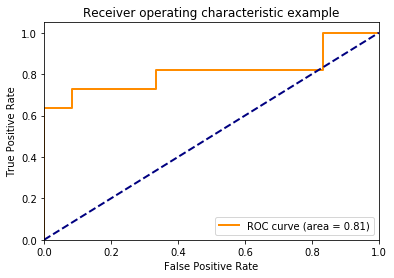

(67, 80)
Selected 80 from 159 features.


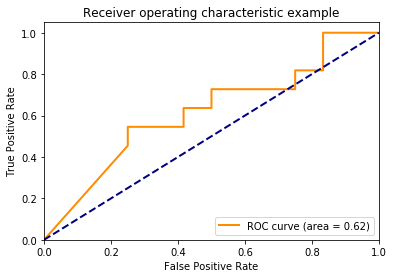

(68, 80)
Selected 80 from 159 features.


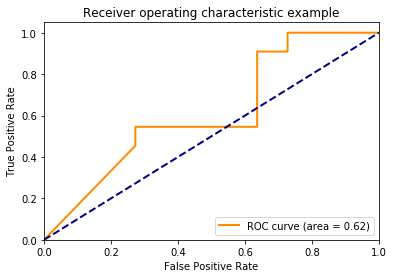

(68, 80)
Selected 80 from 159 features.


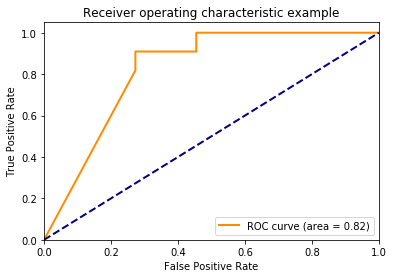

In [18]:
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
#for _ in range(0,20):
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    train_scores = []
    test_scores = []
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Lasso
    # Now first use the selectfrom model module. Select all features with a weight above the median.
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train_lasso = selector.transform(X_train_scaled)
    X_validation_lasso = selector.transform(X_validation_scaled)
    n_selected = X_train_lasso.shape[1]
    print(X_train_lasso.shape)
    print(f"Selected {n_selected} from {n_original} features.")

    # Fit the LDA on selected features
    clf = LDA()
    clf.fit(X_train_lasso, y_train)
    y_score = clf.predict_proba(X_validation_lasso)
    plot_roc_curve(y_score, y_validation)

    # ## 3. PCA
    # pca = PCA().fit(X_train_lasso)
    # # Plotting the Cumulative Summation of the Explained Variance
    # plt.figure()
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.xlabel('Number of Components')
    # plt.ylabel('Cumulative Explained Variance')
    # plt.title('Explained Variance')
    # plt.show()

    # # 3. PCA
    # # Using the Cumulative Summation of the Explained Variance, we concluded that to  
    # # retain 95% of the variance we need to use 30 components.
    # pca = decomposition.PCA(n_components=30)
    # pca.fit(X_train_lasso)
    # X_train_pca = pca.transform(X_train_lasso)
    # X_validation_pca = pca.transform(X_validation_lasso)
    # print(X_train_pca)
    # Fit the LDA on selected features





In [16]:
# Now first use the selectfrom model module. Select all features with a weight above the median.
selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
selector.fit(X_train_scaled, y_train)
n_original = X_train_scaled.shape[1]
X_train = selector.transform(X_train_scaled)
X_test = selector.transform(split_X_test)
n_selected = X_train.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

# Fit the LDA on selected features
clf = LDA()
clf.fit(X_train, y_train)
y_score = clf.predict_proba(split_X_test)
plot_roc_curve(y_score, split_y_test)

NameError: name 'X_train_scaled' is not defined

In [ ]:
# Lasso classification
# Display the weights and compute error for multiple values for alpha
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(X_train, y_train)
    duration = time() - t0
    y_pred = clf.predict(X_test)
    message = ("\t Misclassified: %d / %d" % ((y_test != y_pred).sum(), y_test.shape[0]))
    print(message)
    
    # Append statistics
    accuracy = float((y_test != y_pred).sum()) / float(y_test.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()

# Note: you may get a FutureWarning, which you can for now just ignore